# CSC413 Lab 5: Transfer Learning and Descent

Transfer learning is a technique where we use neural network weights trained
to complete one task to complet a different task.
In this tutorial, we will go through an example of *transfer learning* to
detect American Sign Language (ASL) gestures letters A-I.
Although we could train a CNN from scratch,
you will see that using CNN weights that are pretrained on a larger dataset and
more complex task provides much better results, all with less training.

American Sign Language (ASL) is a complete, complex language that employs signs made by
moving the hands combined with facial expressions and postures of the body.
It is the primary language of many North Americans who are deaf and is one of several
communication options used by people who are deaf or hard-of-hearing.

The hand gestures representing English alphabets are shown below. This lab focuses on
classifying a subset of these hand gesture images using convolutional neural networks.
Specifically, given an image of a hand showing one of the letters A-I, we want to detect
which letter is being represented.

![Image](https://www.lifeprint.com/asl101/fingerspelling/images/abc1280x960.png)

By the end of this lab, you will be able to:

1. Analyze the role of batch normalization and other model architecture choice in a neural network.
2. Define the double descent phenomenon and explain why it occurs.
3. Analyze the shape of the training curve of a convolutional neural network with respect to the double descent phenomenon.
4. Apply transfer learning to solve an image classification task.
5. Compare transfer learning vs. training a CNN from scratch.
6. Identify and suggest corrections for model building issues by inspecting misclassified data.


Acknowledgements:

- Data is collected from a previous machine learning course APS360. Only data
  of students who provided consent is included.

Please work in groups of 1-2 during the lab.

## Submission

If you are working with a partner, start by creating a group on Markus.
If you are working alone,
click "Working Alone".

Submit the generated PDF file `lab05.pdf` on Markus
**containing all your solutions to the Graded Task**s.
Your file must contain your code **and outputs** where applicable,
including printed lines and images.
Your TA will not run your code for the purpose of grading.

For this lab, you should submit the following:

- Part 1. Your answer to the question about the splitting of the data into train/validation/test sets. (1 point)
- Part 2. Your comparison of the CNN model with and without batch normalization. (1 point)
- Part 2. Your comparison of `BatchNorm1d` vs `BatchNorm2d`.  (1 point)
- Part 2. Your analysis of the effect of varying the CNN model width. (1 point)
- Part 2. Your analysis of the effect of varying weight decay parameter. (1 point)
- Part 2. Your analysis of the training curve that illustrates double descent. (1 point)
- Part 3. Your implementation of `LinearModel` for transfer learning. (1 point)
- Part 3. Your comparison of transfer learning vs the CNN model. (1 point)
- Part 4. Your analysis of the confusion matrix. (1 point)
- Part 4. Your explanation for how to mitigate an issue we notice by visually inspecting misclassified images. (1 point)

In [ ]:
import matplotlib
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models, torchvision.datasets

%matplotlib inline

## Part 1. Data

We will begin by downloading the data onto Google Colab.

In [ ]:
# Download lab data file
!wget https://www.cs.toronto.edu/~lczhang/413/asl_data.zip
!unzip asl_data.zip

--2024-03-15 14:49:45--  https://www.cs.toronto.edu/~lczhang/413/asl_data.zip
Resolving www.cs.toronto.edu (www.cs.toronto.edu)... 128.100.3.30
Connecting to www.cs.toronto.edu (www.cs.toronto.edu)|128.100.3.30|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5750695 (5.5M) [application/zip]
Saving to: ‘asl_data.zip’

asl_data.zip        100%[===================>]   5.48M  6.54MB/s    in 0.8s    

2024-03-15 14:49:47 (6.54 MB/s) - ‘asl_data.zip’ saved [5750695/5750695]

Archive:  asl_data.zip
   creating: asl_data/
   creating: asl_data/valid/
   creating: asl_data/test/
   creating: asl_data/train/
   creating: asl_data/valid/I/
   creating: asl_data/valid/G/
   creating: asl_data/valid/A/
   creating: asl_data/valid/F/
   creating: asl_data/valid/H/
   creating: asl_data/valid/C/
   creating: asl_data/valid/D/
   creating: asl_data/valid/E/
   creating: asl_data/valid/B/
   creating: asl_data/test/I/
   creating: asl_data/test/G/
   creating: asl_data/test/A/

The file structure we use is intentional,
so that we can use `torchvision.datasets.ImageFolder`
to help load our data and create labels.

You can read what `torchvision.datasets.ImageFolder` does for us here
https://pytorch.org/docs/stable/torchvision/datasets.html#imagefolder

In [ ]:
train_path = "asl_data/train/" # edit me
valid_path = "asl_data/valid/" # edit me
test_path = "asl_data/test/"   # edit me

train_data = torchvision.datasets.ImageFolder(train_path, transform=torchvision.transforms.ToTensor())
valid_data = torchvision.datasets.ImageFolder(valid_path, transform=torchvision.transforms.ToTensor())
test_data = torchvision.datasets.ImageFolder(test_path, transform=torchvision.transforms.ToTensor())

As in previous labs, we can iterate through the dataset one training data point at a time like this:

tensor([[[0.6706, 0.6549, 0.6275,  ..., 0.6706, 0.6706, 0.6706],
         [0.6706, 0.6549, 0.6314,  ..., 0.6706, 0.6706, 0.6706],
         [0.6706, 0.6549, 0.6314,  ..., 0.6706, 0.6706, 0.6706],
         ...,
         [0.5647, 0.5765, 0.5137,  ..., 0.8902, 0.8902, 0.8902],
         [0.5569, 0.5765, 0.5176,  ..., 0.8902, 0.8902, 0.8902],
         [0.5569, 0.5765, 0.5176,  ..., 0.8902, 0.8902, 0.8902]],

        [[0.6588, 0.6431, 0.6157,  ..., 0.6588, 0.6588, 0.6588],
         [0.6588, 0.6431, 0.6196,  ..., 0.6588, 0.6588, 0.6588],
         [0.6588, 0.6431, 0.6196,  ..., 0.6588, 0.6588, 0.6588],
         ...,
         [0.5725, 0.5843, 0.5176,  ..., 0.8902, 0.8902, 0.8902],
         [0.5647, 0.5843, 0.5216,  ..., 0.8902, 0.8902, 0.8902],
         [0.5647, 0.5843, 0.5216,  ..., 0.8902, 0.8902, 0.8902]],

        [[0.6392, 0.6235, 0.5961,  ..., 0.6314, 0.6314, 0.6314],
         [0.6392, 0.6235, 0.6000,  ..., 0.6314, 0.6314, 0.6314],
         [0.6392, 0.6235, 0.6000,  ..., 0.6314, 0.6314, 0.

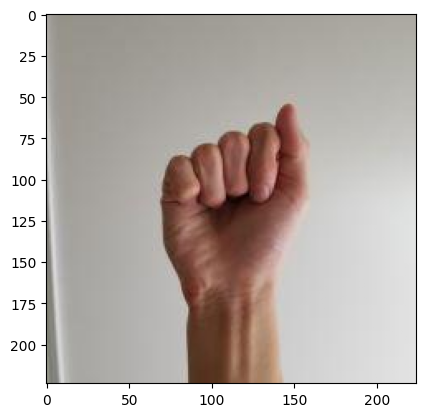

In [ ]:
for x, t in train_data:
    print(x, t)
    plt.imshow(x.transpose(2, 0).transpose(0, 1).numpy()) # display an image
    break # uncomment if you'd like

**Task**: What do the variables `x` and `t` contain? What is the shape of our images?
What are our labels? Based on what you learned in Part (a), how were the
labels generated from the folder structure?

In [ ]:
# Your explanation goes here
"""
x is the rgb representation of a 224x224-pixel image.
t is the class of the hand gesture.
"""

'\nx is the rgb representation of a 224x224-pixel image.\nt is the class of the hand gesture.\n'

We saw in the earlier tutorials that PyTorch has a utility to help us
creat minibatches with our data. We can use the same DataLoader helper
here:

In [ ]:
train_loader = torch.utils.data.DataLoader(train_data, batch_size=10, shuffle=True)

for x, t in train_loader:
    print(x, t)
    break # uncomment if you'd like

tensor([[[[0.7216, 0.7333, 0.7412,  ..., 0.7529, 0.7569, 0.7569],
          [0.7255, 0.7333, 0.7412,  ..., 0.7529, 0.7529, 0.7569],
          [0.7294, 0.7333, 0.7412,  ..., 0.7490, 0.7490, 0.7490],
          ...,
          [0.5686, 0.5686, 0.5647,  ..., 0.7059, 0.7098, 0.7098],
          [0.5608, 0.5608, 0.5608,  ..., 0.7098, 0.7098, 0.7137],
          [0.5569, 0.5569, 0.5569,  ..., 0.7137, 0.7137, 0.7176]],

         [[0.6824, 0.6941, 0.7020,  ..., 0.7137, 0.7176, 0.7176],
          [0.6863, 0.6941, 0.7020,  ..., 0.7137, 0.7137, 0.7176],
          [0.6902, 0.6941, 0.7020,  ..., 0.7098, 0.7098, 0.7098],
          ...,
          [0.5333, 0.5333, 0.5294,  ..., 0.6745, 0.6784, 0.6784],
          [0.5255, 0.5255, 0.5255,  ..., 0.6784, 0.6784, 0.6824],
          [0.5216, 0.5216, 0.5216,  ..., 0.6824, 0.6824, 0.6863]],

         [[0.6353, 0.6471, 0.6549,  ..., 0.6667, 0.6706, 0.6706],
          [0.6392, 0.6471, 0.6549,  ..., 0.6667, 0.6667, 0.6706],
          [0.6431, 0.6471, 0.6549,  ..., 0

**Task**: What do the variables `x` and `t` contain? What are their shapes?
What data do they contain?

In [ ]:
# Your explanation goes here
"""
x contains 10 224x224-pixel rgb images.
t contains 10 target for each image.
"""

'\nx contains 10 224x224-pixel rgb images.\nt contains 10 target for each image.\n'

**Task**: How many images are there in the training, validation, and test sets?

In [ ]:
# Your explanation goes here
print(len(train_data))
print(len(valid_data))
print(len(test_data))

207
733
223


Notice that there are *fewer* images in the training set, compared to the validation and test sets.
This is so that we can explore the effect of having a limited training set.

**Graded Task**: The data set is generated by students taking pictures of their hand
while making the corresponding gestures. We therefore split the
training, validation, and test sets were split so that images generated by
a student all belongs in a single data set. In other words, we avoid cases where
some students' images are in the training set and others end up in the test set.
Why do you think this is important for obtaining a representative test accuracy?

In [ ]:
# Your explanation goes here
"""
It is important to keep gestures from same people in a single dataset.
We want our model to learn pattern from the gestures among different people and
generalize this pattern instead of learning student-specific features. Since
gestures made by same people may be dependent, keeping same person's gestures
in a single dataset also make sure that all dataset are independent from each other.
"""

"\nStudents' hand shape and gestures may vary a lot, which prevent the model from\nlearning effectively?\n# TODO\n"

## Part 2. Training a CNN Model

For this part, we will be working with this CNN network.

In [ ]:
class CNN(nn.Module):
    def __init__(self, width=4, bn=True):
        """
        A 4-layer convolutional neural network. The first layer has
        `width` number of channels, and with each layer we half the
        feature width/height and double the number of channels.

        If `bn` is set to False, then batch normalization will not run.
        """
        super(CNN, self).__init__()
        self.width = width
        self.bn = bn
        # define all the conv layers
        self.conv1 = nn.Conv2d(in_channels=3,
                               out_channels=self.width,
                               kernel_size=3,
                               padding=1)
        self.conv2 = nn.Conv2d(in_channels=self.width,
                               out_channels=self.width*2,
                               kernel_size=3,
                               padding=1)
        self.conv3 = nn.Conv2d(in_channels=self.width*2,
                               out_channels=self.width*4,
                               kernel_size=3,
                               padding=1)
        self.conv4 = nn.Conv2d(in_channels=self.width*4,
                               out_channels=self.width*8,
                               kernel_size=3,
                               padding=1)
        # define all the BN layers
        if bn:
            self.bn1 = nn.BatchNorm2d(self.width)
            self.bn2 = nn.BatchNorm2d(self.width*2)
            self.bn3 = nn.BatchNorm2d(self.width*4)
            self.bn4 = nn.BatchNorm2d(self.width*8)
        # pooling layer has no parameter, so one such layer
        # can be shared across all conv layers
        self.pool = nn.MaxPool2d(2, 2)
        # FC layers
        self.fc1 = nn.Linear(self.width * 8 * 14 * 14, 100)
        self.fc2 = nn.Linear(100, 9)
    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        if self.bn:
            x = self.bn1(x)
        x = self.pool(torch.relu(self.conv2(x)))
        if self.bn:
            x = self.bn2(x)
        x = self.pool(torch.relu(self.conv3(x)))
        if self.bn:
            x = self.bn3(x)
        x = self.pool(torch.relu(self.conv4(x)))
        if self.bn:
            x = self.bn4(x)
        x = x.view(-1, self.width * 8 * 14 * 14)
        x = torch.relu(self.fc1(x))
        return self.fc2(x)

**Task**: The training code is written for you. Train the `CNN()` model for at least 6 epochs, and report
on the maximum validation accuracy that you can attain.

As your model is training, you might want to move on to the next question.

In [ ]:
def get_accuracy(model, data, device="cpu"):
    loader = torch.utils.data.DataLoader(data, batch_size=256)
    model.to(device)
    model.eval() # annotate model for evaluation (important for batch normalization)
    correct = 0
    total = 0
    for imgs, labels in loader:
        labels = labels.to(device)
        output = model(imgs.to(device))
        pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
        correct += pred.eq(labels.view_as(pred)).sum().item()
        total += imgs.shape[0]
    return correct / total

def train_model(model,
                train_data,
                valid_data,
                batch_size=64,
                weight_decay=0.0,
                learning_rate=0.001,
                num_epochs=50,
                plot_every=20,
                plot=True,
                device=torch.device("cuda:0" if torch.cuda.is_available() else "cpu")):
    train_loader = torch.utils.data.DataLoader(train_data,
                                               batch_size=batch_size,
                                               shuffle=True)
    model = model.to(device) # move model to GPU if applicable
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(),
                           lr=learning_rate,
                           weight_decay=weight_decay)
    # for plotting
    iters, train_loss, train_acc, val_acc = [], [], [], []
    iter_count = 0 # count the number of iterations that has passed

    try:
        for epoch in range(num_epochs):
            for imgs, labels in iter(train_loader):
                if imgs.size()[0] < batch_size:
                    continue
                labels = labels.to(device)
                imgs = imgs.to(device)
                model.train()
                out = model(imgs)
                loss = criterion(out, labels)
                loss.backward()
                optimizer.step()
                optimizer.zero_grad()

                iter_count += 1
                if iter_count % plot_every == 0:
                    loss = float(loss)
                    tacc = get_accuracy(model, train_data, device)
                    vacc = get_accuracy(model, valid_data, device)
                    print("Iter %d; Loss %f; Train Acc %.3f; Val Acc %.3f" % (iter_count, loss, tacc, vacc))

                    iters.append(iter_count)
                    train_loss.append(loss)
                    train_acc.append(tacc)
                    val_acc.append(vacc)
    finally:
        plt.figure()
        plt.plot(iters[:len(train_loss)], train_loss)
        plt.title("Loss over iterations")
        plt.xlabel("Iterations")
        plt.ylabel("Loss")

        plt.figure()
        plt.plot(iters[:len(train_acc)], train_acc)
        plt.plot(iters[:len(val_acc)], val_acc)
        plt.title("Accuracy over iterations")
        plt.xlabel("Iterations")
        plt.ylabel("Accuracy")
        plt.legend(["Train", "Validation"])

**Task**: Run the training code below. What validation accuracy can be achieved by this CNN?

Iter 25; Loss 0.018799; Train Acc 0.242; Val Acc 0.188
Iter 50; Loss 0.001169; Train Acc 0.971; Val Acc 0.506
Iter 75; Loss 0.000694; Train Acc 1.000; Val Acc 0.577
Iter 100; Loss 0.000456; Train Acc 1.000; Val Acc 0.584
Iter 125; Loss 0.000540; Train Acc 1.000; Val Acc 0.577
Iter 150; Loss 0.000288; Train Acc 1.000; Val Acc 0.576


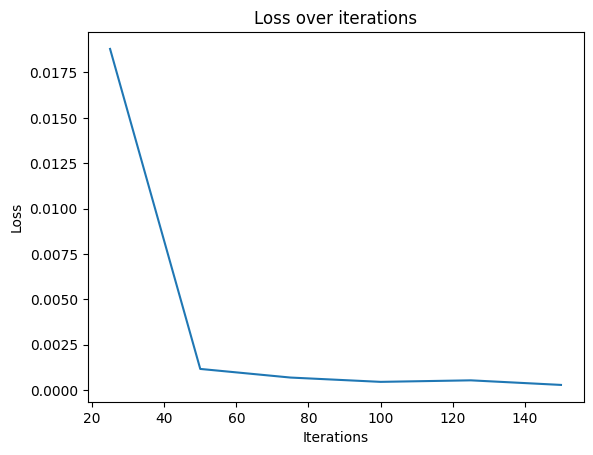

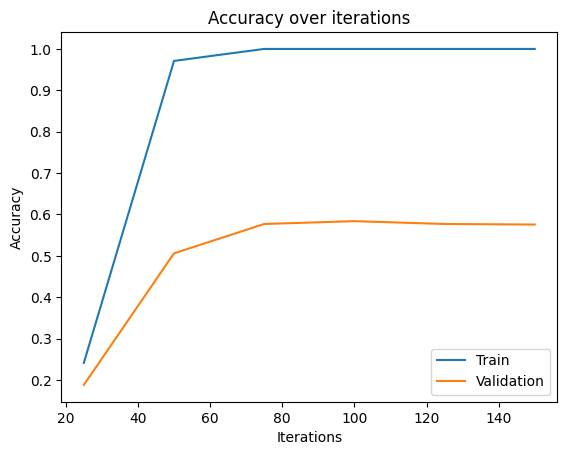

In [ ]:
cnn = CNN(width=4)
train_model(cnn, train_data, valid_data, batch_size=64, learning_rate=0.001, num_epochs=50, plot_every=25)

## Part 2. Model Architecture, Bias/Variance and Double Descent

In this section, we will explore the effect of various aspects of
a CNN model architecture. We will pay particluar attention to
architecture decisions that affect the bias and variance of the
model. Finally, we explore a phenomenon called **double descent**.


To begin, let's explore the effect of batch normalization.

**Task**: Run the training code below to explore the effect of training *without* batch normalization.

Iter 25; Loss 2.166883; Train Acc 0.227; Val Acc 0.179
Iter 50; Loss 1.124182; Train Acc 0.638; Val Acc 0.397
Iter 75; Loss 0.278522; Train Acc 0.903; Val Acc 0.501
Iter 100; Loss 0.129329; Train Acc 0.981; Val Acc 0.503
Iter 125; Loss 0.025692; Train Acc 1.000; Val Acc 0.548
Iter 150; Loss 0.004784; Train Acc 1.000; Val Acc 0.518


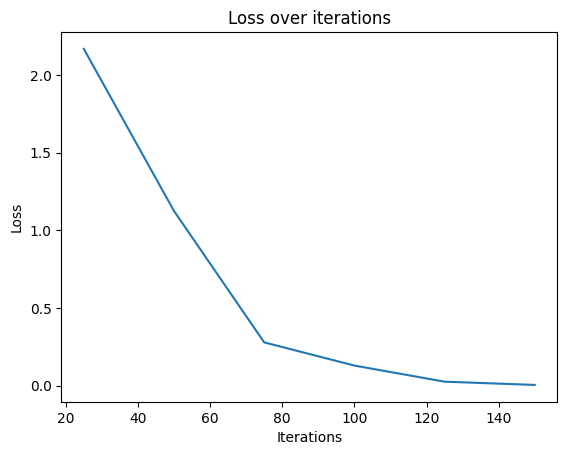

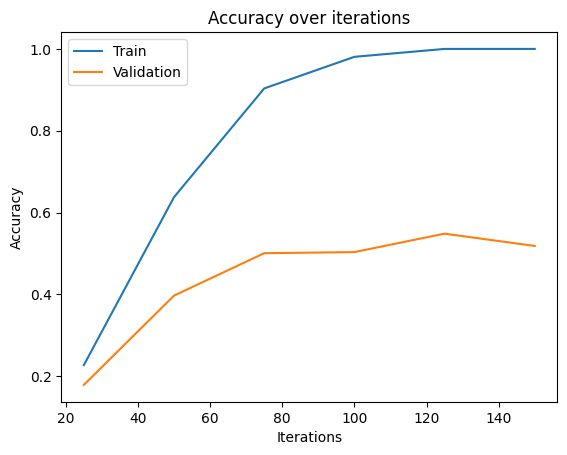

In [ ]:
cnn = CNN(bn=False)
train_model(cnn, train_data, valid_data, batch_size=64, learning_rate=0.001, num_epochs=50, plot_every=25)

**Graded Task**: Compare the two sets of training curves above for the CNN model with and without
batch normalization. What is the effect of batch normalization on the training loss and accuracy?
What about the validation accuracy?

In [68]:
# TODO: Include your analysis here
"""
Batch normalization fasten the training process. The training loss drops faster
and the accuracy increases faster due to batch normalization comparing the
above two graphs. The validation accuracy of the model with BN appears to be
more stable and higher than the plain version due to the regularization effect
BN have. Moreover, in the plain version, the validation accuracy start to drop
vastly at the end, which doesn't happen in the model with BN.
"""

"\nBatch normalization fasten the training process. The training loss drops faster\nand the accuracy increases faster due to batch normalization comparing the\nabove two graphs. The validation accuracy of the model with BN appears to be \nmore stable and higher than the plain version. Moreover, in the plain version, \nthe validation accuracy start to drop vastly at the end, which doesn't happen \nin the model with BN.\n"

**Graded Task**:
We used the layer called `BatchNorm2d` in our CNN.
What do you think is the difference between `BatchNorm2d` and `BatchNorm1d`?
Why are we using `BatchNorm2d` in our CNN? Why would we use `BatchNorm1d` in an MLP?
You may wish to consult the PyTorch documentation. (How can you find it?)

In [71]:
# Explain your answer here
"""
The dimension that these two BN can work on are different. From PyTorch documentation,
for BatchNorm2d, the inputs are (N, C, H, W). Where N is the batch size,
C is the number of channels, and H and W represent the size of the images.
This is setting is exactly what we have in our CNN and that is why we used it here.
for BatchNorm1d, the input are (N,C) or (N,C,L), so that we are processing on
flatten vector instead of matrices or images.
"""

'\nThe dimension that these two BN can work on are different. From PyTorch documentation,\nfor BatchNorm2d, the inputs are (N, C, H, W). Where N is the batch size,\nC is the number of channels, and H and W represent the size of the images.\nThis is setting is exactly what we have in our CNN and that is why we used it here. \nfor BatchNorm1d, the input are (N,C) or (N,C,L), so that we are processing on \nflatten vector instead of matrices or images.\n'

**Task**: Run the training code below to explore the effect of varying the model width
for this particular data set.

Iter 25; Loss 2.200990; Train Acc 0.130; Val Acc 0.111
Iter 50; Loss 2.131160; Train Acc 0.275; Val Acc 0.210
Iter 75; Loss 1.713706; Train Acc 0.367; Val Acc 0.258
Iter 100; Loss 1.156015; Train Acc 0.662; Val Acc 0.366
Iter 125; Loss 0.771234; Train Acc 0.749; Val Acc 0.442
Iter 150; Loss 0.483164; Train Acc 0.889; Val Acc 0.492


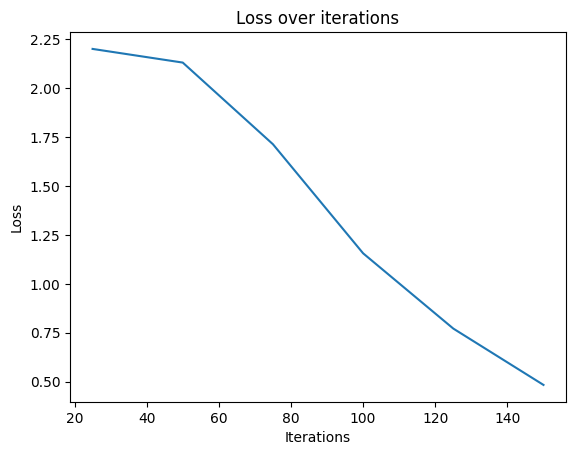

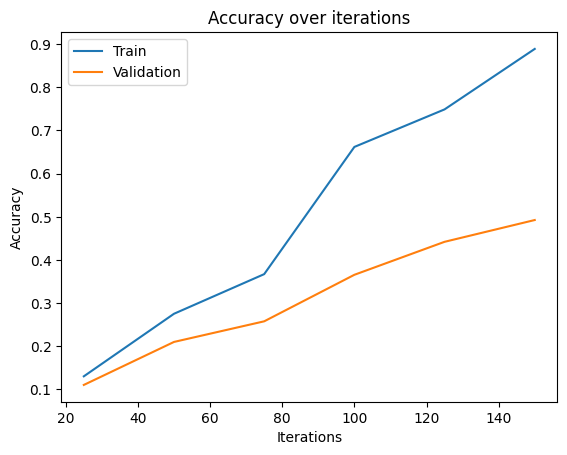

In [ ]:
cnn = CNN(width=2, bn=False)
train_model(cnn, train_data, valid_data, batch_size=64, learning_rate=0.001, num_epochs=50, plot_every=25)

Iter 25; Loss 2.111996; Train Acc 0.386; Val Acc 0.256
Iter 50; Loss 0.995087; Train Acc 0.691; Val Acc 0.432
Iter 75; Loss 0.295610; Train Acc 0.884; Val Acc 0.499
Iter 100; Loss 0.139217; Train Acc 0.961; Val Acc 0.508
Iter 125; Loss 0.026887; Train Acc 0.990; Val Acc 0.513
Iter 150; Loss 0.009688; Train Acc 1.000; Val Acc 0.517


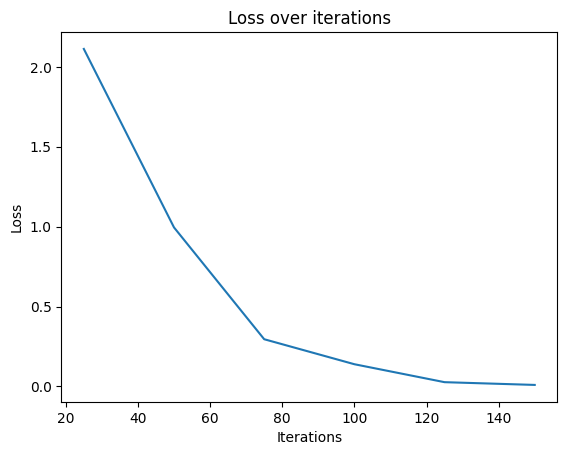

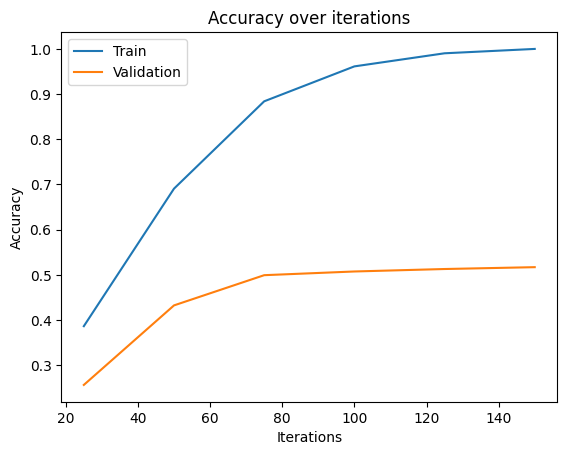

In [ ]:
cnn = CNN(width=4, bn=False)
train_model(cnn, train_data, valid_data, batch_size=64, learning_rate=0.001, num_epochs=50, plot_every=25)

Iter 25; Loss 0.721699; Train Acc 0.691; Val Acc 0.442
Iter 50; Loss 0.202278; Train Acc 0.903; Val Acc 0.551
Iter 75; Loss 0.019092; Train Acc 1.000; Val Acc 0.566
Iter 100; Loss 0.002263; Train Acc 1.000; Val Acc 0.604
Iter 125; Loss 0.000557; Train Acc 1.000; Val Acc 0.613
Iter 150; Loss 0.000270; Train Acc 1.000; Val Acc 0.606


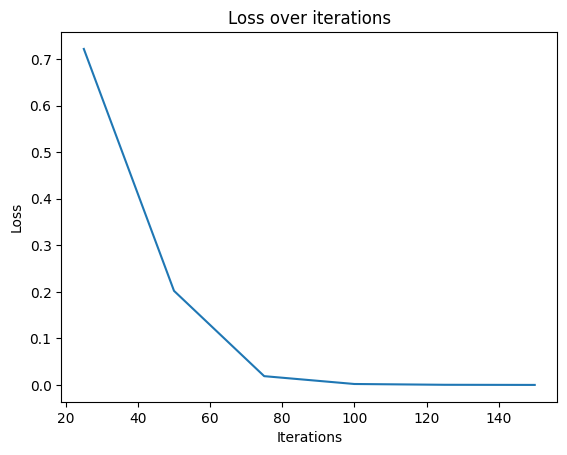

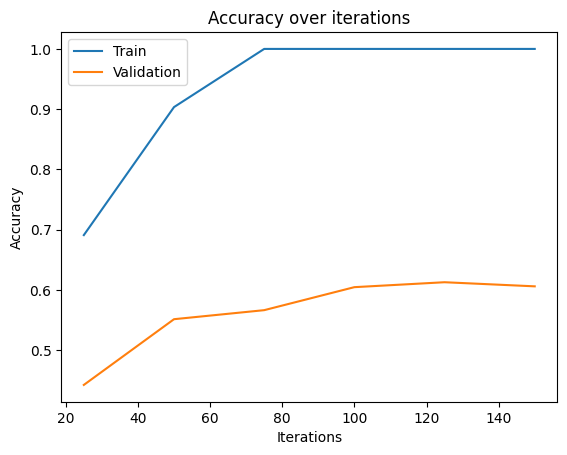

In [ ]:
cnn = CNN(width=16, bn=False)
train_model(cnn, train_data, valid_data, batch_size=64, learning_rate=0.001, num_epochs=50, plot_every=25)

**Graded Task**: What is the effect of varying the model width above for this particular data set?
Do you notice an effect on the training loss? What about the training/validation accuracy?
The final validation accuracy?
(Your answer may or may not match your expectations. Please answer based on the actual results above.)

In [69]:
# TODO: Include your analysis here
"""
We get the higher accuracies and lower loss faster as the width increases.
When the width is set to 2, the model achieved the lowest final validation accuracy,
but it seems that it is still learning since its loss and accuracies don't show
a sign that it is converging.
It is also worth noting that when the width is set to 16, the validation accuracy
started to drop at the end maybe due to overfitting, but it still outperforms the
other two models.
"""

"\nWe get the higher accuracies and lower loss faster as the width increases.\nWhen the width is set to 2, the model achieved the lowest validation accuracy, \nbut it seems that it is still learning since its loss and accuracies don't show \na sign that it is converging. \nIt is also worth noting that when the width is set to 16, the validation accuracy\nstarted to drop at the end maybe due to overfitting, but it still outperform the \nother two models.\n"

**Task**: Run the training code below to explore the effect of weight decay when training a large model.

Iter 25; Loss 1.129138; Train Acc 0.638; Val Acc 0.424
Iter 50; Loss 0.402852; Train Acc 0.918; Val Acc 0.562
Iter 75; Loss 0.047992; Train Acc 0.995; Val Acc 0.580
Iter 100; Loss 0.001439; Train Acc 1.000; Val Acc 0.580
Iter 125; Loss 0.000703; Train Acc 1.000; Val Acc 0.570
Iter 150; Loss 0.000802; Train Acc 1.000; Val Acc 0.570


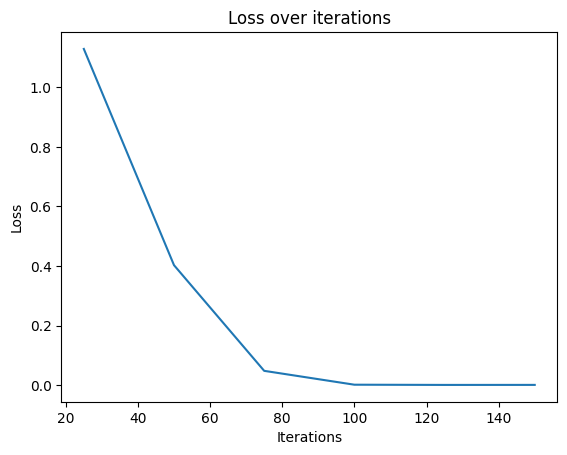

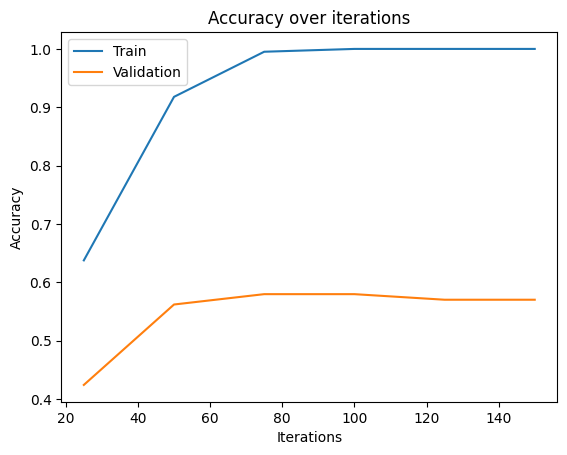

In [ ]:
cnn = CNN(width=16, bn=False)
train_model(cnn, train_data, valid_data, batch_size=64, learning_rate=0.001, num_epochs=50, plot_every=25, weight_decay=0.001)

Iter 25; Loss 0.029944; Train Acc 0.174; Val Acc 0.153
Iter 50; Loss 0.002759; Train Acc 0.932; Val Acc 0.538
Iter 75; Loss 0.000954; Train Acc 1.000; Val Acc 0.628
Iter 100; Loss 0.000367; Train Acc 1.000; Val Acc 0.621
Iter 125; Loss 0.000465; Train Acc 1.000; Val Acc 0.608
Iter 150; Loss 0.000683; Train Acc 1.000; Val Acc 0.614


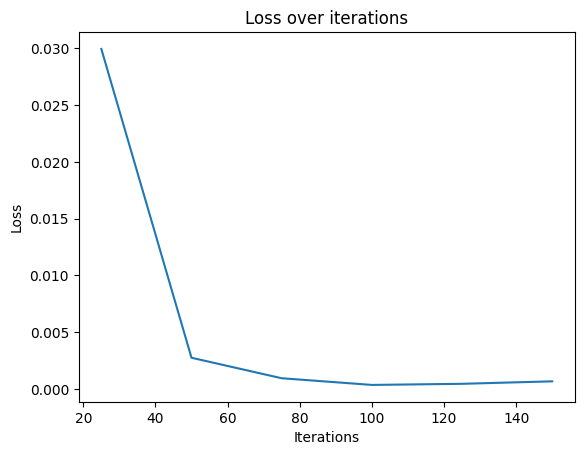

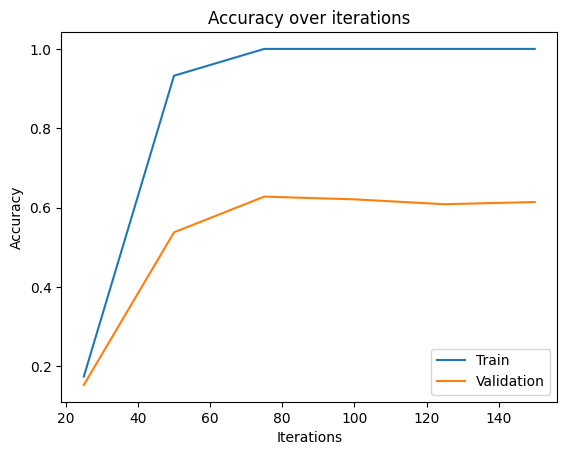

In [ ]:
cnn = CNN(width=16, bn=True) # try with batch norm on
train_model(cnn, train_data, valid_data, batch_size=64, learning_rate=0.001, num_epochs=50, plot_every=25, weight_decay=0.001)

Iter 25; Loss 0.013903; Train Acc 0.164; Val Acc 0.131
Iter 50; Loss 0.001023; Train Acc 0.957; Val Acc 0.532
Iter 75; Loss 0.000352; Train Acc 1.000; Val Acc 0.581
Iter 100; Loss 0.000453; Train Acc 1.000; Val Acc 0.577
Iter 125; Loss 0.000236; Train Acc 1.000; Val Acc 0.580
Iter 150; Loss 0.000292; Train Acc 1.000; Val Acc 0.580


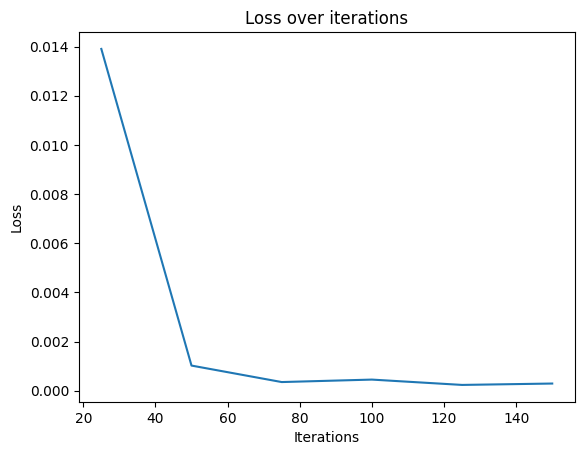

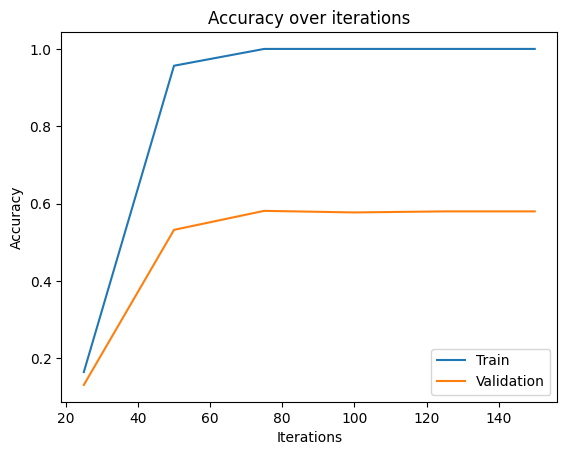

In [70]:
cnn = CNN(width=16, bn=True) # try decreasing weight decay parameter
train_model(cnn, train_data, valid_data, batch_size=64, learning_rate=0.001, num_epochs=50, plot_every=25, weight_decay=0.0001)

**Graded Task**: What is the effect of setting weight decay to the above value?
Do you notice an effect on the training loss? What about the training/validation accuracy?
The final validation accuracy?
(Again, your answer may or may not match your expectations. Please answer based on the actual results above.)

In [ ]:
# TODO: Include your analysis here
"""
Weight decay reduce the level of overfitting.
The training loss decreases faster with weight decay and BN.
The training and validation accuracy increases faster with weight dacay and BN.
The validation accuracy dropped after 75 iterations for all models.
When we activate BN and the larger weight decay coefficient we get the
highest validation accuracy, the other two models achieves the same final validation
accuracy.
"""

"\nWeight decay reduce the level of overfitting, but when with BN, we can't use a large\nlambda for weight decay, this may due to that BN also has an effect of regularization.\nThe training loss decreases faster with weight decay and even faster with BN.\nthe training and validation accuracy increases faster with weight dacay and BN but\nthe validation accuracy dropped after some iterations except for the last one (where we\nactivate both BN and weight decay), therefore the last one is more stable.\nWhen we activate BN and a higher weight decay coefficient we get the lowest validation\naccuracy.\n"

**Task**: Note that there is quite a bit of noise in the results that we might obtain above.
That is, if you run the same code twice, you may obtain different answers.
Why might that be? What are two sources of noise/randomness?

In [ ]:
# TODO: Include your explanation here
"""
- The initial parameters of pytorch models are random, which will lead to
different behaviours of the same type of the models.
-
"""

'\n- The initial parameters of pytorch models are random, which will lead to\ndifferent behaviours of the same type of the models.\n-\n'

These settings that we have been exporting are hyperparameters that should
be tuned when you train a neural network. These hyperparameters interact with
one another, and thus we should tune them using the **grid search** strategy
mentioned in previous labs.

You are not required to perform grid search for this lab, so that we can
explore a few other phenomena.

One interesting phenomenon is called **double descent**. In statistical learning theory,
we expect validation error to *decrease* with increase model capacity, and then *increase*
as the model overfits to the number of data points available for training.
In practise, in neural networks, we often see that as model capacity increases,
validation error first decreases, then increase, and then **decrease again**---hence
the name "double descent".

In fact, the increase in validation error is actually quite subtle.
However, what is readily apparent is that in most cases, increasing
model capacity does *not* result in a decrease in validation accuracy.

**Optional Task**: To illustrate that validation accuracy is unlikely to decrease
with increased model parameter, train the below network.

In [ ]:
# Uncomment to run.
# cnn = CNN(width=40, bn=True)
# train_model(cnn, train_data, valid_data, batch_size=64, learning_rate=0.001, num_epochs=50, plot_every=50)

Double descent is actually not that mysterious. It comes from the fact that
when capacity is large enough there are many parameter choices that achieves 100% training accuracy,
the neural network optimization procedure is effectively choosing a *best parameters*
out of the many that can achieve this perfect training accuracy. This differs from
when capacity is low, where the optimization process needs to find a set of parameter choices that
best fits the training data---since no choice of parameters fits the training data perfectly.
When the capacity is just large enough to be able to find parameters that fit the data,
but too small for there be a range of parameter choices available to be able to select a "best" one.

This twitter thread written by biostatistics professor Daniela Witten
also provides an intuitive explanation, using polynomial curve fitting
as an example: [https://twitter.com/daniela_witten/status/1292293102103748609](https://twitter.com/daniela_witten/status/1292293102103748609)

Double descent explored in depth in this paper here:
[https://openreview.net/pdf?id=B1g5sA4twr](https://openreview.net/pdf?id=B1g5sA4twr)
This paper highlights that the increase in validation/test error occurs
when the training accuracy approximates 100%.
Moreover, the double descent phenomena is noticable when varying model capacity (e.g. number of parameters)
and when varying the number of iterations/epochs of training.

We will attempt to explore the latter effect---i.e. we will train a large model, use a small
number of training data points, and explore how each iteration of training impacts validation accuracy.
The effect is subtle and, depending on your neural network initialization, you may not see an effect.
An examplary training curve is also provided for you to analyze.

**Optional Task**: Run the code below to try and reproduce the "double descent" phenomena.
This code will take a while to run, so you may wish to continue with the remaining questions
while it runs.

In [27]:
# use a subset of the training data
# uncomment to train

# train_data_subset, _ =  random_split(train_data, [50, len(train_data)-50])
# cnn = CNN(width=20)
# train_model(cnn,
#             train_data_subset,
#             valid_data,
#             batch_size=50, # set batch_size=len(train_data_subset) to minimize training noise
#             num_epochs=200,
#             plot_every=1,  # plot every epoch (this is slow)
#             learning_rate=0.0001)  # choose a low learning rate

NameError: name 'random_split' is not defined

For reference, here is the our training curve showing the loss and accuracy over 200 iterations:

<img src="https://www.cs.toronto.edu/~lczhang/413/double_descent_loss.png" width=400>
<img src="https://www.cs.toronto.edu/~lczhang/413/double_descent.png" width=400>

It might not be possible to consistently reproduce this result (e.g., due to initialization),
so it is totally reasonable for your figure to look different!


**Task**: In the provided training curve,
during which iterations does the validation accuracy initially increase
(i.e. validation error decrease)?

In [ ]:
# TODO: Include your answer here

**Graded Task**: In the provided training curve,
during which iterations do the validation accuracy decrease slightly?
Approximately what training accuracy is achieved at this piont?

In [ ]:
# TODO: Include your answer here
"""
During iteration 65-80. A validation accuracy of 40% is achieved at 65-th iteration
and it drops abour 2% at 80-th iteration.
"""

**Task**: In the provided training curve,
during which iterations do the validation accuracy increase for a second time
(i.e. validation error descends for a second time)?

In [ ]:
# TODO: Include your answer here

## Part 3. Transfer Learning

For many image classification tasks, it is generally not a good idea to train a
very large deep neural network model from scratch due to the enormous compute
requirements and lack of sufficient amounts of training data.

A better option is to try using an existing model that performs a
similar task to the one you need to solve. This method of utilizing a
pre-trained network for other similar tasks is broadly termed
**Transfer Learning**. In this assignment, we will use Transfer Learning
to extract features from the hand gesture images. Then, train a smaller
network to use these features as input and classify the hand gestures.

As you have learned from the CNN lecture, convolution layers extract various
features from the images which get utilized by the fully connected layers
for correct classification. AlexNet architecture played a pivotal role in
establishing Deep Neural Nets as a go-to tool for image classification
problems and we will use an ImageNet pre-trained AlexNet model to
extract features in this assignment.

Here is the code to load the AlexNet network, with pretrained weights.
When you first run the code, PyTorch will download the pretrained weights
from the internet.

In [28]:
import torchvision.models
alexnet = torchvision.models.alexnet(pretrained=True)

print(alexnet)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth
100%|██████████| 233M/233M [00:05<00:00, 47.6MB/s]


AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

As you can see, the `alexnet` model is split up into two components:
`alexnet.features` and
`alexnet.classifier`.  The first neural network component, `alexnet.features`,
is used to
computed convolutional features, which is taken as input in `alexnet.classifier`.

The neural network `alexnet.features` expects an image tensor of shape
Nx3x224x224 as inputs and it will output a tensor of shape Nx256x6x6 . (N = batch size).

Here is an example code snippet showing how you can compute the AlexNet
features for some images (your actual code might be different):

In [44]:
img, label = train_data[0]
features = alexnet.features(img.unsqueeze(0)).detach()

# print(img, img.unsqueeze(0))
print(features.shape)

torch.Size([1, 256, 6, 6])


Note that the `.detach()` at the end will be necessary in your code. The reason is that
PyTorch automatically builds computation graphs to be able to backpropagate
graidents. If we did not explicitly "detach" this tensor from the AlexNet portion
of the computation graph, PyTorch might try to backpropagate gradients to the AlexNet
weight and tune the AlexNet weights.

**Task**: Compute the AlexNet features for each of your training, validation, and test data
by completing the function `compute_features`.
The code below creates three new arrays called `train_data_fets`, `valid_data_fets`
and `test_data_fets`. Each of these arrays contains tuples of the form
`(alexnet_features, label)`.

In [42]:
alexnet.features.eval()

def compute_features(data):
    fets = []
    for img, t in data:
        features = alexnet.features(img.unsqueeze(0)).detach()
        fets.append((features, t),)
    return fets

train_data_fets = compute_features(train_data)
valid_data_fets = compute_features(valid_data)
test_data_fets = compute_features(test_data)

In the rest of this part of the lab, we will test two models that
will take **as input** these AlexNet features, and make a prediction
for which letter the hand gesture represents.
The two models are
a linear model, a two-layer MLP.
We will compare the performance of these two models.

**Graded Task**: Complete the definition of the `LinearModel` class,
which is a linear model (e.g., logistic regression).
This model should as input these AlexNet features, and make a prediction
for which letter the hand gesture represents.

In [45]:
class LinearModel(nn.Module):
    def __init__(self):
        super(LinearModel, self).__init__()
        # TODO: What layer need to be initialized?
        self.lin = nn.Linear(256 * 6 * 6, 9)
        self.sigmoid = nn.Sigmoid()


    def forward(self, x):
        x = x.view(-1, 256 * 6 * 6) # flatten the input
        z = self.lin(x) # TODO: What computation needs to be performed?
        return self.sigmoid(z)

m_linear = LinearModel()
m_linear(train_data_fets[0][0]) # this should produce a(n unnormalized) prediction

tensor([[0.5015, 0.3182, 0.3832, 0.3317, 0.3029, 0.5808, 0.5989, 0.6868, 0.6433]],
       grad_fn=<SigmoidBackward0>)

**Task**:
Train a `LinearModel()` for at least 6 epochs, and report
on the maximum validation accuracy that you can attain.
We should still be able to use the `train_model` function, but
make sure to provide the AlexNet features as input (and not the
image features).

Iter 20; Loss 1.461744; Train Acc 0.879; Val Acc 0.764
Iter 40; Loss 1.411511; Train Acc 0.981; Val Acc 0.899
Iter 60; Loss 1.387078; Train Acc 1.000; Val Acc 0.883
Iter 80; Loss 1.382746; Train Acc 1.000; Val Acc 0.888
Iter 100; Loss 1.380089; Train Acc 1.000; Val Acc 0.895
Iter 120; Loss 1.377191; Train Acc 1.000; Val Acc 0.900
Iter 140; Loss 1.376646; Train Acc 1.000; Val Acc 0.902


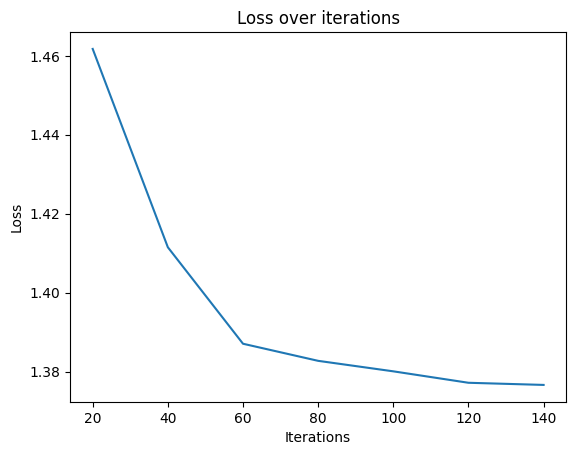

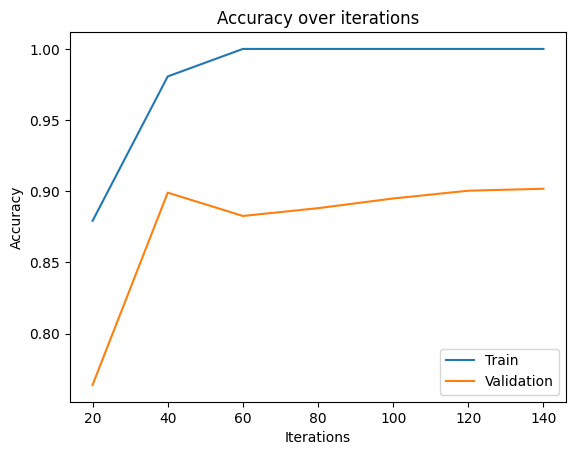

In [54]:
m_linear = LinearModel()
# TODO: Train the linear model. Include your output in your submission
train_model(m_linear, train_data_fets, valid_data_fets, num_epochs=50,
            batch_size=64, weight_decay=0.001, plot_every=20)

**Graded Task**: Compare this model with the CNN() models that we trained
earlier. How does this model perform in terms of validation accuracy?
What about in terms of the time it took to train this model?

In [ ]:
# TODO: Your observation goes here
"""

The best validation accuracy we get is 90%, which is much higher than the CNN model
we trained (60%). This is because we used pre-trained AlexNet features that is very helpful
for learning images. The time it takes to train this model is much faster since we
use the extracted features from pre-trained AlexNet, which cost no time, plus the training
time for this very simple linear model.
"""

**Task**:
We decide to use AlexNet features as input to our MLP, and avoided tuning AlexNet
weights. However, we could have considered AlexNet to be a part of our model, and
continue to tune AlexNet weights to improve our model performance. What are the
advantages and disadvantages of continuing to tune AlexNet weights?

In [ ]:
# TODO
"""
Pros: to make AlexNet model fit better to our data.
COns: may lose generalization or hurt model performance
"""

## Part 4. Data

**Task**: Report the test accuracy on this transfer learning model.

In [65]:
# TODO
get_accuracy(m_linear, test_data_fets)

0.8026905829596412

**Task**: Use this code below to construct the confusion matrix for this model
over the test set.

<Figure size 640x480 with 0 Axes>

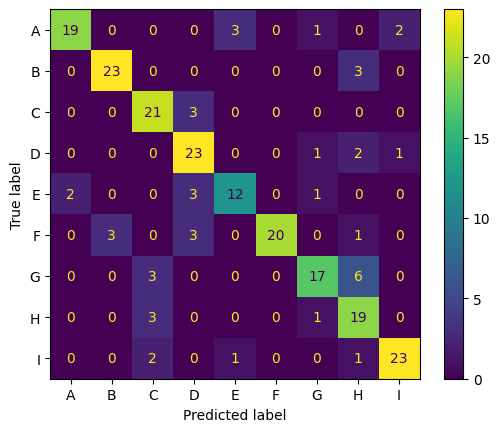

In [55]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import sklearn
label = "ABCDEFGHI"
def plot_confusion(model, data):
    n = 0
    ts = []
    ys = []
    for x, t in data:
        z = model(x.unsqueeze(0))
        y = int(torch.argmax(z))
        ts.append(t)
        ys.append(y)

    cm = confusion_matrix(ts, ys)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label)
    plt.figure()
    disp.plot()

plot_confusion(m_linear, test_data_fets)

**Graded Task**: Which class is most likely mistaken as another?
Is this reasonable? (i.e. is that class particularly challenging, or
very similar to another class?)

In [ ]:
# TODO: Include your analysis here
"""
Class G is most likely mistaken as other classes and has 9 instances classified
as other classes. Specifically, 6 of class G is misclassified as class H, which
is 2 times higher than any other misclassifications.
It is reasonable that there are 6 of class G is classified as H since both gestures
looks quite similar. We are not sure why 3 of them is classified as C, it could be
the after feature extraction by AlexNet, they have similar features and thus our model
misclassified them.
"""

**Task**: In order to understand where errors come from, it is *crucial* that
we explore why and how our models fail. A first step is to visually inspect the
test data points where failure occurs. That way, we can identify what we can do
to prevent/fix errors before our models are deployed.

Run the below code to display images in the test set that our model *misclassifies*:

In [66]:
for i, (x, t) in enumerate(test_data_fets):
    y = int(torch.argmax(m_linear(x)))
    if not (y == t):
        plt.figure()
        plt.imshow(test_data[i][0].transpose(0,1).transpose(1,2).numpy())

Output hidden; open in https://colab.research.google.com to view.

**Task**: By visually inspecting these misclassified images, we see that there are
two main reasons for misclassification. What reason for misclassification is
due to a mistake in the formatting of the test set images?

In [ ]:
# TODO

**Graded Task**: We also see a much more serious issue, where gestures made by
individuals with darker skin tones may be more frequently misclasified.
This result suggests that errors in the model may impact some groups more than
others. What steps should we take to mitigate this issue?

In [ ]:
# TODO
"""
- Our training dataset is really small, it can't generalized well to predict people
with different skin colors. Therefore we need a much larger dataset to train on.
- It is also possible that there are only few data points that is dark-skin
toned. To mitigate this, we need a more diversed and balanced training set, so that
the ratios people with different skin tone are roughly the same.
- Although with the pretrained AlexNet, our linear model is too simple. Since we are training
over our own dataset, the final output may be changed a lot to fit our dataset.
We should also consider to use a more complicated model to learn more complicated
pattern and features preprocessed by AlexNet.
- The quality of the images in our dataset isn't good, the background color are
inconsistent across the dataset. Since it can affect the people's skin tone,
we may need to consider using the same background.
"""